# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

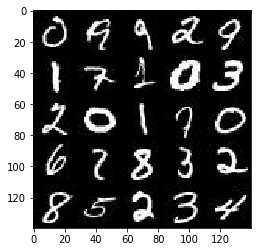

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

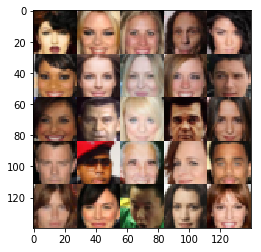

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    lr = tf.placeholder(tf.float32, shape = (), name='learning_rate')
    

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):       
        
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')        
        relu1 = tf.maximum(alpha * conv1, conv1)
        #now 14x14x64
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        batch2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * batch2, batch2)
        #now 7x7x128
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        batch3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * batch3, batch3)
        #now 4x4x256
        
        conv4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        batch4 = tf.layers.batch_normalization(conv4, training=True)
        relu3 = tf.maximum(alpha * batch4, batch4)
        #now 2x2x512
        
        # flatten
        flatten = tf.reshape(conv4, (-1, 2*2*512))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
    
    return (out, logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        
        alpha=0.2 #using for leak relu
        
        #make a fully connected layer
        fully = tf.layers.dense(z, 4*4*512)
        #reshape tensor to 3 dim
        full= tf.reshape(fully, (-1, 4, 4, 512))
        full = tf.layers.batch_normalization(full, training=is_train)        
        full = tf.maximum(alpha * full, full)
        #now 4x4x512
        
        #make deconvolation (transpose convolotaion) to make generator 28x28x(out_channel_dim) image
        deconv1 = tf.layers.conv2d_transpose(full, 256, 4, strides=1, padding='VALID')
        deconv1 = tf.layers.batch_normalization(deconv1, training=is_train) 
        l_relu1 = tf.maximum(deconv1 * alpha, deconv1)
        #now 7x7x256
        
        deconv2 = tf.layers.conv2d_transpose(l_relu1, 128, 5, strides=2, padding='SAME')
        deconv2 = tf.layers.batch_normalization(deconv2, training = is_train)
        l_relu2 = tf.maximum(deconv2*alpha, deconv2)
        #now 14x14x128
        
        deconv3 = tf.layers.conv2d_transpose(l_relu2, 64, 5, strides=2, padding='SAME')
        deconv3 = tf.layers.batch_normalization(deconv3, training = is_train)
        l_relu3 = tf.maximum(deconv3*alpha, deconv3)
        #now 28x28x64
        
        
        #output_layer
        logits = tf.layers.conv2d_transpose(l_relu3, out_channel_dim, 5, strides=1, padding = 'SAME')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real,
                                                                           labels=tf.ones_like(disc_model_real)*(1 - smooth)))
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                           labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                     labels=tf.ones_like(disc_model_fake)))
    
    disc_loss = disc_loss_real + disc_loss_fake
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    #get weights and bias to update
    train_vars = tf.trainable_variables()
    gen_vars = [x for x in train_vars if x.name.startswith('generator')]
    disc_vars = [x for x in train_vars if x.name.startswith('discriminator')]
    
    #optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10
    show_every = 100
    step = 0
    
    samples, width, height, channels = data_shape
    
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                 # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0

                # Run optimizers
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                steps += 1
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9340... Generator Loss: 11.8302
Epoch 1/2... Discriminator Loss: 0.8913... Generator Loss: 16.4714
Epoch 1/2... Discriminator Loss: 0.6697... Generator Loss: 2.1610
Epoch 1/2... Discriminator Loss: 0.4754... Generator Loss: 3.8786
Epoch 1/2... Discriminator Loss: 0.6964... Generator Loss: 11.6778
Epoch 1/2... Discriminator Loss: 0.6715... Generator Loss: 29.4454
Epoch 1/2... Discriminator Loss: 0.5233... Generator Loss: 5.1310
Epoch 1/2... Discriminator Loss: 0.3966... Generator Loss: 5.0809
Epoch 1/2... Discriminator Loss: 0.8728... Generator Loss: 9.7366
Epoch 1/2... Discriminator Loss: 0.4392... Generator Loss: 3.3873


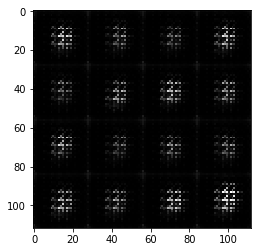

Epoch 1/2... Discriminator Loss: 6.4887... Generator Loss: 33.5918
Epoch 1/2... Discriminator Loss: 0.8293... Generator Loss: 2.5285
Epoch 1/2... Discriminator Loss: 0.5791... Generator Loss: 4.7278
Epoch 1/2... Discriminator Loss: 0.3785... Generator Loss: 6.1268
Epoch 1/2... Discriminator Loss: 2.4370... Generator Loss: 0.4990
Epoch 1/2... Discriminator Loss: 1.7397... Generator Loss: 4.4976
Epoch 1/2... Discriminator Loss: 0.7386... Generator Loss: 4.4038
Epoch 1/2... Discriminator Loss: 0.4125... Generator Loss: 5.4993
Epoch 1/2... Discriminator Loss: 0.3989... Generator Loss: 4.2413
Epoch 1/2... Discriminator Loss: 0.4216... Generator Loss: 4.6560


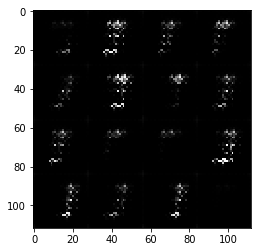

Epoch 1/2... Discriminator Loss: 2.2437... Generator Loss: 0.2575
Epoch 1/2... Discriminator Loss: 0.6940... Generator Loss: 2.8653
Epoch 1/2... Discriminator Loss: 0.4844... Generator Loss: 4.6845
Epoch 1/2... Discriminator Loss: 1.0162... Generator Loss: 2.8269
Epoch 1/2... Discriminator Loss: 0.6219... Generator Loss: 5.4394
Epoch 1/2... Discriminator Loss: 1.6350... Generator Loss: 7.2667
Epoch 1/2... Discriminator Loss: 0.8215... Generator Loss: 4.5742
Epoch 1/2... Discriminator Loss: 1.3305... Generator Loss: 1.2069
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 4.9772
Epoch 1/2... Discriminator Loss: 0.8875... Generator Loss: 2.2821


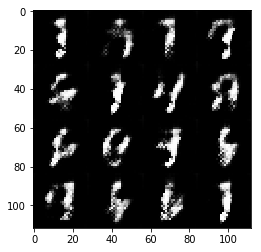

Epoch 1/2... Discriminator Loss: 0.8225... Generator Loss: 2.3781
Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 0.8159
Epoch 1/2... Discriminator Loss: 0.7144... Generator Loss: 2.6490
Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 4.5983
Epoch 1/2... Discriminator Loss: 1.3378... Generator Loss: 0.8439
Epoch 1/2... Discriminator Loss: 1.0726... Generator Loss: 3.8663
Epoch 1/2... Discriminator Loss: 1.1941... Generator Loss: 0.8837
Epoch 1/2... Discriminator Loss: 0.8249... Generator Loss: 2.0002
Epoch 1/2... Discriminator Loss: 1.3163... Generator Loss: 3.0530
Epoch 1/2... Discriminator Loss: 0.9308... Generator Loss: 1.6317


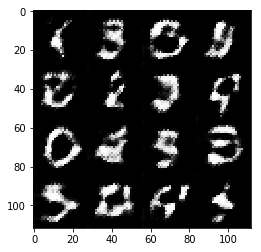

Epoch 1/2... Discriminator Loss: 1.0716... Generator Loss: 0.9002
Epoch 1/2... Discriminator Loss: 1.4053... Generator Loss: 2.3997
Epoch 1/2... Discriminator Loss: 1.0507... Generator Loss: 0.9629
Epoch 1/2... Discriminator Loss: 1.1967... Generator Loss: 0.7871
Epoch 1/2... Discriminator Loss: 1.1095... Generator Loss: 2.4677
Epoch 1/2... Discriminator Loss: 0.9656... Generator Loss: 1.4027
Epoch 2/2... Discriminator Loss: 0.8985... Generator Loss: 1.7198
Epoch 2/2... Discriminator Loss: 1.1328... Generator Loss: 1.3797
Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 1.5053
Epoch 2/2... Discriminator Loss: 0.9846... Generator Loss: 1.5876


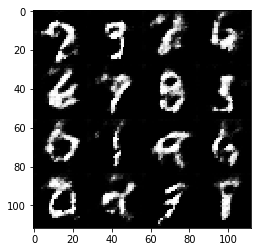

Epoch 2/2... Discriminator Loss: 1.0528... Generator Loss: 1.5525
Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.6733
Epoch 2/2... Discriminator Loss: 1.0792... Generator Loss: 1.0781
Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 0.7671
Epoch 2/2... Discriminator Loss: 1.0257... Generator Loss: 1.5250
Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 2.3266
Epoch 2/2... Discriminator Loss: 1.1350... Generator Loss: 2.0345
Epoch 2/2... Discriminator Loss: 1.0465... Generator Loss: 1.6119
Epoch 2/2... Discriminator Loss: 0.9997... Generator Loss: 1.5235
Epoch 2/2... Discriminator Loss: 1.1531... Generator Loss: 0.7552


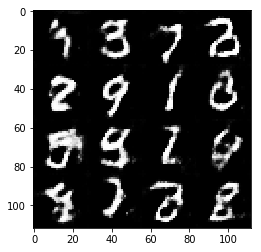

Epoch 2/2... Discriminator Loss: 0.9862... Generator Loss: 1.1765
Epoch 2/2... Discriminator Loss: 1.0495... Generator Loss: 1.1567
Epoch 2/2... Discriminator Loss: 1.2159... Generator Loss: 0.7716
Epoch 2/2... Discriminator Loss: 1.0955... Generator Loss: 0.9006
Epoch 2/2... Discriminator Loss: 1.2167... Generator Loss: 0.7512
Epoch 2/2... Discriminator Loss: 1.2228... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 0.9713... Generator Loss: 1.3881
Epoch 2/2... Discriminator Loss: 1.4621... Generator Loss: 0.5127
Epoch 2/2... Discriminator Loss: 0.9783... Generator Loss: 1.2349
Epoch 2/2... Discriminator Loss: 1.1166... Generator Loss: 1.8421


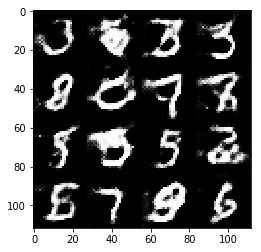

Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 1.8592
Epoch 2/2... Discriminator Loss: 1.1613... Generator Loss: 1.6114
Epoch 2/2... Discriminator Loss: 1.2621... Generator Loss: 2.2128
Epoch 2/2... Discriminator Loss: 1.0564... Generator Loss: 1.3796
Epoch 2/2... Discriminator Loss: 1.0328... Generator Loss: 1.5698
Epoch 2/2... Discriminator Loss: 1.1388... Generator Loss: 1.6298
Epoch 2/2... Discriminator Loss: 1.0410... Generator Loss: 1.4753
Epoch 2/2... Discriminator Loss: 1.3274... Generator Loss: 1.8556
Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 1.5947
Epoch 2/2... Discriminator Loss: 1.5297... Generator Loss: 2.1885


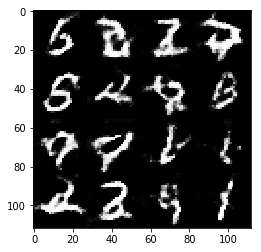

Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 0.7541
Epoch 2/2... Discriminator Loss: 1.1314... Generator Loss: 1.3294
Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 1.7071
Epoch 2/2... Discriminator Loss: 1.0985... Generator Loss: 1.6206
Epoch 2/2... Discriminator Loss: 0.9833... Generator Loss: 1.2551
Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 0.5576
Epoch 2/2... Discriminator Loss: 1.3307... Generator Loss: 0.5841
Epoch 2/2... Discriminator Loss: 1.0172... Generator Loss: 1.4682
Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 0.5979
Epoch 2/2... Discriminator Loss: 0.9505... Generator Loss: 1.2619


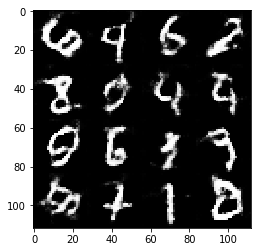

Epoch 2/2... Discriminator Loss: 1.1235... Generator Loss: 0.8085
Epoch 2/2... Discriminator Loss: 1.0015... Generator Loss: 1.1161
Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 1.6122


In [24]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.9689... Generator Loss: 9.4426
Epoch 1/1... Discriminator Loss: 2.8577... Generator Loss: 9.5920
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 1.5106
Epoch 1/1... Discriminator Loss: 7.9295... Generator Loss: 0.0008
Epoch 1/1... Discriminator Loss: 2.5581... Generator Loss: 16.7450
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 11.5320
Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 1.6865
Epoch 1/1... Discriminator Loss: 0.6284... Generator Loss: 1.6640
Epoch 1/1... Discriminator Loss: 0.6029... Generator Loss: 1.8805


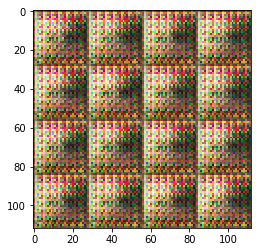

Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 21.4566
Epoch 1/1... Discriminator Loss: 5.2863... Generator Loss: 0.0146
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 8.7420
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.1758
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 3.6419
Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 2.0366
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 2.1129... Generator Loss: 0.2961
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.6609


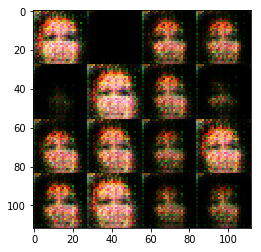

Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 2.6169
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 3.1130
Epoch 1/1... Discriminator Loss: 3.8776... Generator Loss: 9.0936
Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 1.4071
Epoch 1/1... Discriminator Loss: 1.9430... Generator Loss: 4.9492
Epoch 1/1... Discriminator Loss: 1.6474... Generator Loss: 4.6266
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 1.6546
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.9535


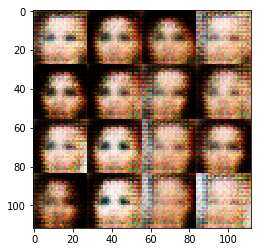

Epoch 1/1... Discriminator Loss: 1.7081... Generator Loss: 0.5323
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 2.0376
Epoch 1/1... Discriminator Loss: 1.6630... Generator Loss: 2.3928
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 3.8332
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.6024... Generator Loss: 0.5055
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 2.8586
Epoch 1/1... Discriminator Loss: 1.5826... Generator Loss: 0.5288


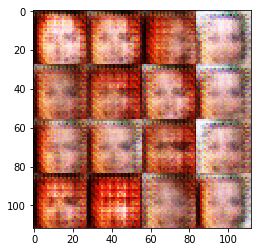

Epoch 1/1... Discriminator Loss: 0.8223... Generator Loss: 1.8214
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.6726... Generator Loss: 0.3930
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 1.4461
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.6546... Generator Loss: 0.3685
Epoch 1/1... Discriminator Loss: 2.1847... Generator Loss: 0.3355
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 1.3985
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 2.6791
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.8407


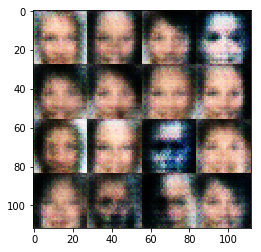

Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 3.9922
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 1.8866
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.9851... Generator Loss: 2.8459
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 2.1029
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 2.2688
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 2.4907
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.8770


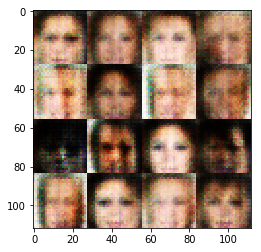

Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 1.0998
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 1.9035
Epoch 1/1... Discriminator Loss: 1.8325... Generator Loss: 3.0352
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 2.1752
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 1.7352... Generator Loss: 0.3778
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 2.1144
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.5261
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 1.1132


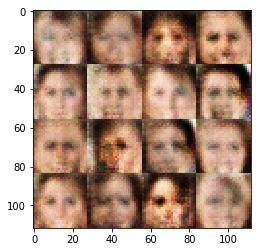

Epoch 1/1... Discriminator Loss: 1.7166... Generator Loss: 3.4544
Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.2787
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 1.8142
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 1.7989... Generator Loss: 3.0194
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 2.7743
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 1.1193
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 1.2150


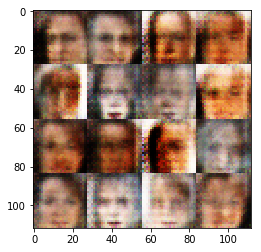

Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.4950
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 1.1447
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 1.7345
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.5145
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 1.4801
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 1.4374


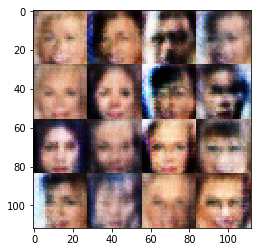

Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 1.8579
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.4098
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 1.4111
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 1.6056
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 1.2234
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 1.4209
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.7115... Generator Loss: 0.3321
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 1.7353


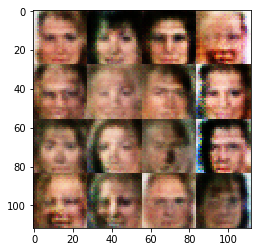

Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 2.2255
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 1.6021... Generator Loss: 2.0514
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 2.0255
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.7595
Epoch 1/1... Discriminator Loss: 1.6064... Generator Loss: 0.3805
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 1.1770
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 1.4955
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 0.9272


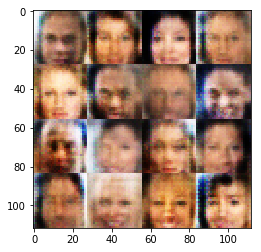

Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.4272
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.5172
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.6602... Generator Loss: 0.3622
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 1.5857
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 1.1957
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 0.8009... Generator Loss: 1.4080


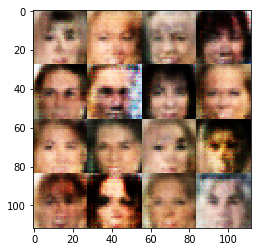

Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 1.9498... Generator Loss: 2.7147
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 1.3450
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.1553
Epoch 1/1... Discriminator Loss: 1.6200... Generator Loss: 0.3567
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.3998


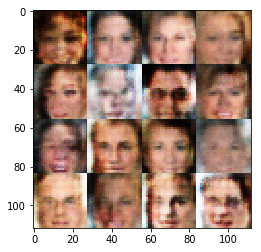

Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.1706
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 1.0228
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 1.2413
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 1.8144
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.4099
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.2427


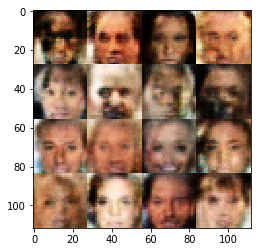

Epoch 1/1... Discriminator Loss: 1.6789... Generator Loss: 0.3479
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 1.3872
Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 1.4466
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 1.8700
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 1.0907
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.8209


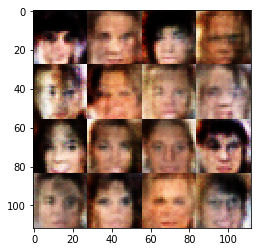

Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.5143
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.7076... Generator Loss: 0.3409
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.7639... Generator Loss: 0.2956
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.9887


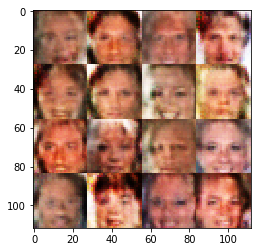

Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 1.3009
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 1.4527
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.5194
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 2.4587
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 1.6456... Generator Loss: 0.3635
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 1.4244


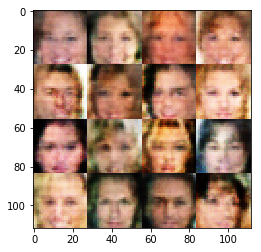

Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 2.2444
Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 1.5134
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 1.6722
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 1.1762
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.7579


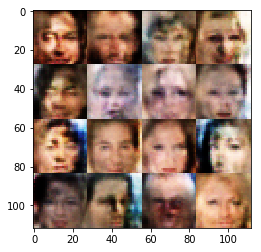

Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 1.5990
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 1.1886
Epoch 1/1... Discriminator Loss: 2.0419... Generator Loss: 2.0989
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 1.1111
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 1.4603
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.1815
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.4794


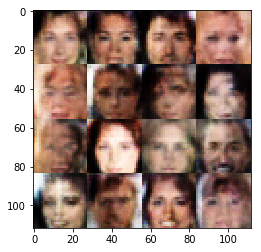

Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 1.1267
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.7601... Generator Loss: 0.3273
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 1.4358


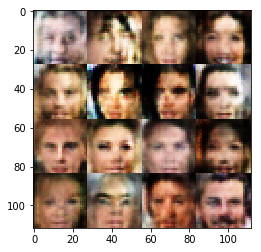

Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.4791
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.3069
Epoch 1/1... Discriminator Loss: 1.5330... Generator Loss: 0.4103
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 1.3481
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 1.4544


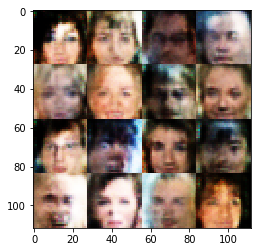

Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 1.7053
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 1.5890
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.5093
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.7637... Generator Loss: 2.3121


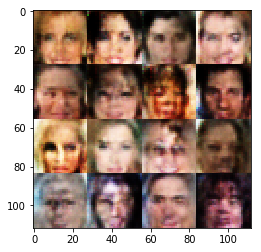

Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 1.0869
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 1.2302
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 1.0308
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 2.7149
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.4576


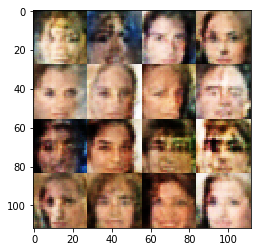

Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 1.3544
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 1.1110
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 1.0092
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 1.0376


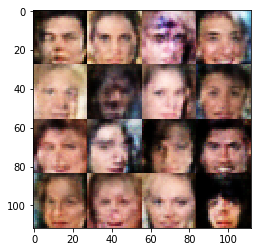

Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.4403
Epoch 1/1... Discriminator Loss: 1.7377... Generator Loss: 0.3393
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.5650
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 1.1726


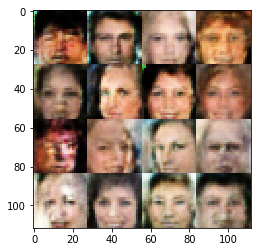

Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 1.9943
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.7972... Generator Loss: 1.5742
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.6192


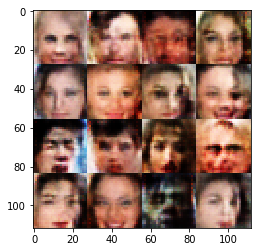

Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.3905
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 1.3359
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.9202


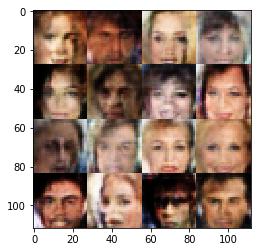

Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.4812
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 1.0122
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 1.6538
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 1.4342
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.4544


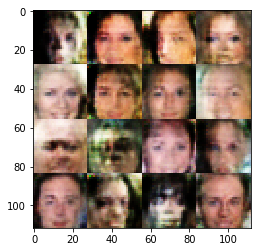

Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 2.1102
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 1.8749... Generator Loss: 0.2613
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.3512
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.4216


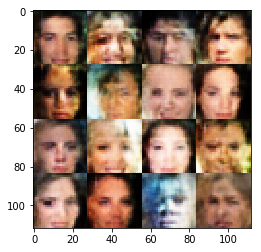

Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 1.2677
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 1.1732
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.6225


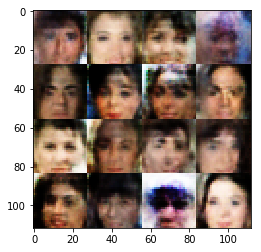

Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.2270
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 2.0925
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 1.1869
Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 1.6537
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 1.1636


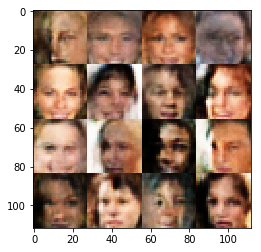

Epoch 1/1... Discriminator Loss: 1.8583... Generator Loss: 3.0494
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 2.2542
Epoch 1/1... Discriminator Loss: 0.7289... Generator Loss: 1.3655
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.9670


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.